In [113]:
import os
from softce_validation import utils
from softce_validation.tasks.available_tasks import get_available_tasks
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import matplotlib.lines as mlines

import numpy as np
from jaxtyping import ArrayLike
import matplotlib.pyplot as plt
os.chdir(utils.get_abspath_project_root())

colors = {
    "True": "tab:green",
    "SoftCE": "tab:orange",
    "ELBO": "tab:blue",
}

In [2]:
from scripts.run_task import run_task
task_names = list(get_available_tasks().keys())
task_names

['linear_regression', 'eight_schools', 'slcp']

In [3]:
task_samples = {}
for task in task_names:
    task_samples[task] = run_task(
        seed=0,
        task_name=task,
        steps=100000,
        return_samples_only = True,
    )


100%|██████████| 100000/100000 [45:26<00:00, 36.68it/s, loss=1.61] 


In [118]:
# Reorder
task_samples = {
    task_name: {k: samps[k] for k in colors.keys()}
    for task_name, samps in task_samples.items()
    }

In [119]:
for task_name, d in task_samples.items():
    jnp.savez(f"_temp/{task_name}_samples.npz", **d)

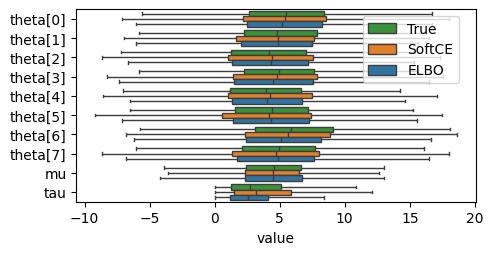

In [121]:
# eight schools
def samples_to_df(samples):
    dfs = []
    for k, samps in samples.items():
        columns = {}
        for name, arr in samps.items():
            if arr.ndim == 1:
                columns[name] = arr
            
            if arr.ndim == 2:
                for i in range(arr.shape[-1]):
                    columns[f"{name}[{i}]"] = arr[:, i]
        df = pd.DataFrame(columns)
        df["source"] = k
        dfs.append(df)

    df = pd.concat(dfs)
    return df.melt(id_vars="source", var_name="parameter", value_name="parameter_value")

samples = task_samples["eight_schools"]

df = samples_to_df(samples)
plt.figure(figsize=(5.15,2.5))
sns.boxplot(
    data=df,
    x="parameter_value",
    y="parameter",
    hue="source",
    showfliers="",
    palette=colors,
    )
plt.legend(bbox_to_anchor=(0.7, 1), loc="upper left")
plt.xlabel("value")
plt.ylabel(None)
plt.savefig("plots/single_run_eight_schools.pdf", bbox_inches='tight')


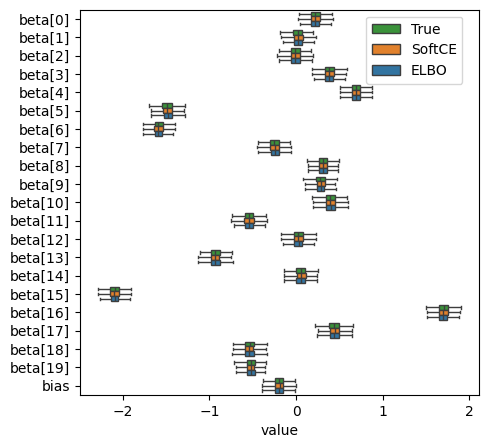

In [122]:
# Linear regression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
samples = task_samples["linear_regression"]

df = samples_to_df(samples)
plt.figure(figsize=(5.15,5))
sns.boxplot(
    data=df,
    x="parameter_value",
    y="parameter",
    hue="source",
    showfliers="",
    palette=colors,
    )
plt.legend(bbox_to_anchor=(0.7, 1), loc="upper left")
plt.xlabel("value")
plt.ylabel(None)
plt.savefig("plots/single_run_linear_regression.pdf", bbox_inches='tight')


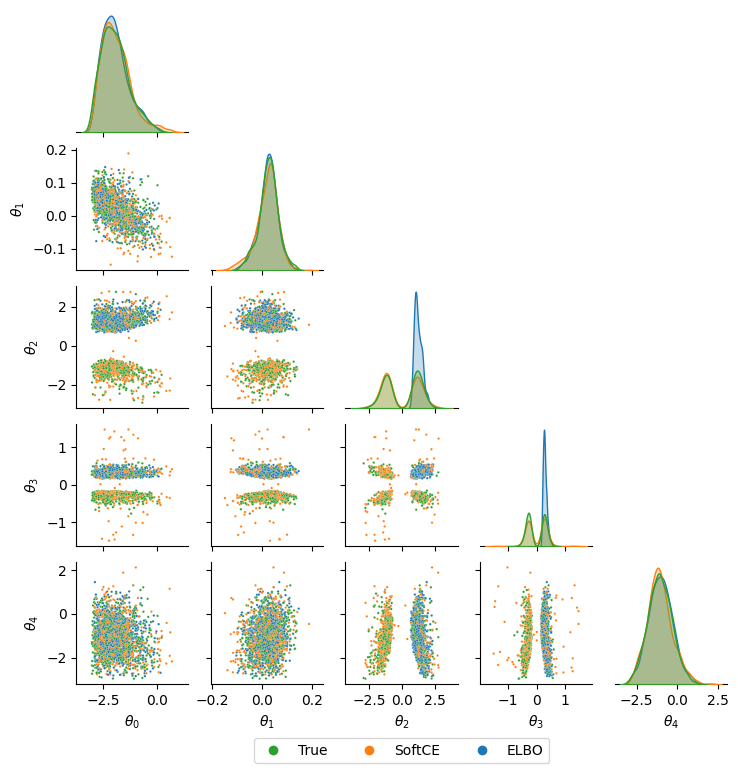

<Figure size 400x400 with 0 Axes>

In [130]:
samples = task_samples["slcp"]
samples = {k: v["theta"] for k, v in samples.items()}

def _filter_outliers(data, n):
    q1 = jnp.nanpercentile(data, 25, axis=0)
    q3 = jnp.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - n * iqr
    upper_bound = q3 + n * iqr
    mask = jnp.logical_and(data >= lower_bound, data <= upper_bound).all(axis=1)
    return data[mask]

def pairplot_dictionary(
    data: dict[str, ArrayLike],
    *,
    column_names: list[str] | None = None,
    filter_outliers: int | float = 3,
    shuffle: bool = True,
    s: int | float = 3,
):
    """Generate a poirplot from a dictionary of arrays."""
    if max(arr.ndim for arr in data.values()) > 2:
        raise ValueError("Arrays must be at most 2 dimensional.")
    data_2d = {
        k: np.random.permutation(arr)
        for k, arr in data.items()
        if arr.ndim == 2
    }
    dfs = []

    if column_names is None:
        column_names = range(list(data_2d.values())[0].shape[1])

    for k, arr in data_2d.items():
        arr = _filter_outliers(arr, filter_outliers)
        df_i = pd.DataFrame(arr, columns=column_names)
        df_i["source"] = k
        dfs.append(df_i)

    df = pd.concat(dfs)

    if shuffle:
        df = df.sample(frac=1)

    df = df.reset_index(drop=True)

    pairplot = sns.pairplot(
        df,
        hue="source",
        plot_kws={"s": s, "rasterized": True},
        diag_kws={"common_norm": False},
        corner=True,
        hue_order=data.keys(),
        height=1.5,
        palette=colors,
    )
    pairplot._legend.remove()  # Point size too small
    return pairplot

g = pairplot_dictionary(
    samples,
    s=3,
    filter_outliers=2.,
    column_names=[fr"$\theta_{i}$" for i in range(5)],
    )


handles = [
    mlines.Line2D(
        [],
        [],
        color=v,
        label=k,
        marker='o',
        linestyle="None",
        )
    for k, v in colors.items()]

plt.legend(handles=handles, ncol=3, loc="lower center", bbox_to_anchor=(-1.9, -0.7))
plt.figure(figsize=(4,4))
g.savefig("plots/single_run_slcp.pdf", bbox_inches="tight")

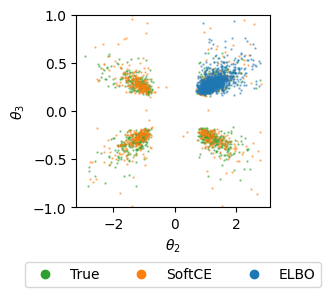

In [147]:
# Plot focussing on the pairwise marginal showing the four modes
for method, samps in samples.items():
    plt.scatter(
        samps[:, 2],
        samps[:, 3],
        label=method,
        s=0.5,
        alpha=0.5,
        rasterized=True,
        color=colors[method],
        )

plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$\theta_3$")
plt.ylim(-1, 1)

# Manual legend to avoid alpha
handles = [
    mlines.Line2D(
        [],
        [],
        color=v,
        label=k,
        marker='o',
        linestyle="None",
        )
    for k, v in colors.items()]

plt.legend(handles=handles, ncol=3, loc="lower center", bbox_to_anchor=(0.5, -0.45))
fig = plt.gcf()
fig.set_size_inches(2.5, 2.5)
fig.savefig("plots/slcp_mass_covering.pdf", bbox_inches="tight")